# Forecasting Time Series

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["grid.color"] = "w"
mpl.rcParams["axes.facecolor"] = "w"
mpl.rcParams["axes.edgecolor"] = "w"
mpl.rcParams["axes.titlecolor"] = "w"
mpl.rcParams["axes.labelcolor"] = "w"
mpl.rcParams["text.color"] = "w"
mpl.rcParams["xtick.color"] = "w"
mpl.rcParams["ytick.color"] = "w"

mpl.rcParams["axes.facecolor"] = "k"
mpl.rcParams["figure.facecolor"] = "k"
mpl.rcParams["figure.figsize"] = (8,6)
mpl.rcParams["axes.grid"] = False

In [2]:
import numpy as np
from tensorflow import keras

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

The following comment might help better understand the implementation of `generate_time_series`:
- `freq1, freq2, offsets1, offsets2` are ndarrays of shape `(batch_size, 1)` with values $\in [0, 1]$
- `time` is an ndarray of shape `(n_steps,)` with first and last value being `0` and `1`
- Frequencies:
  - Frequency is what multiplies the time variable in a (periodic) function
  - `freq1 * 10 + 10` gives minimum frequency `10`, maximum frequency `20`
  - Similarly, `freq2 * 20 + 20` makes the overall frequency value varies uniformly in $[20, 40]$
- `time - offsets` is there to make the waves look different by shifting them
- The `- 0.5` in the noise part is to make the noise both positive and negative
- `np.newaxis` in the `return` is to make the return value an ndarray of shape `(batch_size, n_steps, 1)`
  - Note that this is because series is of shape `(batch_size, n_steps)`, which in turn because of `time - offsets` ([**Broadcasting**](https://numpy.org/doc/stable/user/basics.broadcasting.html))

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

A few words about broadcasting and the way Mr. Geron took `X_train, y_train`:
- Each `X` instance is `series[k, :n_steps]` for some `k`
- Each `y` instance is `series[k, -1]` (i.e. `series[k, n_steps]`) for some `k`
- To be able to do this, we must ensure that `series[k]` is generated by the same `offsets, freq` for all `k`

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "gx", markersize=10, mew=3)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

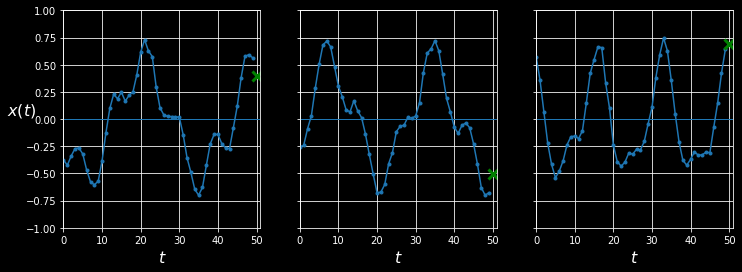

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    #plot_series(X_valid[col, :, 0], y=y_valid[col, 0],
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

#plt.show()

## Baseline Metrics
- Naive forecasting: For each `X` instance, we will take its last value `X[-1]` as our prediction
- Linear regression: Just ordinary linear regression

In [7]:
y_pred = X_valid[:, -1]

**(?1)** Did you notice that in this part in the book the author took mean twice (`np.mean(keras.losses.mean_squared_error(y_valid, y_pred))`)? Why was that?<br>
**(R1)** See below.

In [8]:
keras.losses.mean_squared_error(y_valid, y_pred)

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([0.02696938, 0.0300572 , 0.00259067, ..., 0.00443125, 0.00961478,
       0.04232119], dtype=float32)>

In [9]:
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

The `keras.losses.mean_squared_error()` is really quite crooked. Its mean part probably means that it will take the mean across the dimension of each instance, i.e across the feature values.

Or `keras.losses.mean_squared_error()` expects tensors of shape `(n,)`, but we feeded it `y_pred` and `y_valid` both of
shape `(2000, 1)`

In [10]:
keras.losses.mean_squared_error(np.squeeze(y_valid),
                                np.squeeze(y_pred)).numpy()

0.020211365

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mean_squared_error(y_valid, y_pred)

0.020211367

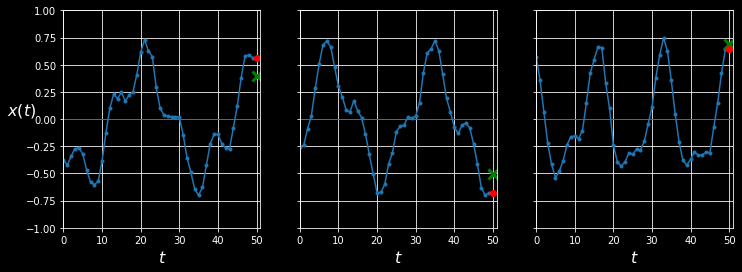

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

In [14]:
y_valid.shape, y_pred.shape

((2000, 1), (2000, 1))

### Linear regression using `sklearn`

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [17]:
np.squeeze(X_train, axis=-1).shape, np.squeeze(y_train, axis=-1).shape

((7000, 50), (7000,))

In [18]:
reg = LinearRegression()
reg.fit(np.squeeze(X_train, axis=-1), np.squeeze(y_train, axis=-1))

LinearRegression()

In [19]:
y_pred = reg.predict(np.squeeze(X_valid, axis=-1))

In [20]:
mean_squared_error(y_valid, y_pred)

0.0029311462

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

### Linear regression using `keras`

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1),
])

In [22]:
%%time
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0)

CPU times: user 4.52 s, sys: 542 ms, total: 5.06 s
Wall time: 3.04 s


In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0036


0.0036224613431841135

In [24]:
# double check our calculations.
y_pred = model.predict(X_valid)
y_pred.shape

(2000, 1)

In [25]:
mean_squared_error(y_valid, y_pred)

0.0036224609

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

## The simplest possible RNN

In [26]:
import tensorflow as tf

In [29]:
%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=(None, 1)),
])
optimizer = keras.optimizers.Adam(lr=0.005)
#model.compile(optimizer="adam", loss="mse")
model.compile(optimizer=optimizer, loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

CPU times: user 1min 57s, sys: 8.97 s, total: 2min 6s
Wall time: 1min 6s


It seems that **RNN takes longer to train**.

In [30]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.010881561785936356

**(?)** The result of our experiment is worse than that in the book. Why is that? Just because of the random seed? Or it's because we have used `adam` optimizer with the default learning rate?<br>
**(R)** Yes, those two factors count for the performance diff.

In [ ]:
y_pred = model.predict(X_valid)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

## Deeper RNN

In [31]:
%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])
optimizer = keras.optimizers.Adam(lr=0.005)
#model.compile(optimizer="adam", loss="mse")
model.compile(optimizer=optimizer, loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

CPU times: user 4min 53s, sys: 28.4 s, total: 5min 21s
Wall time: 1min 51s


In [32]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0030


0.0030256707686930895

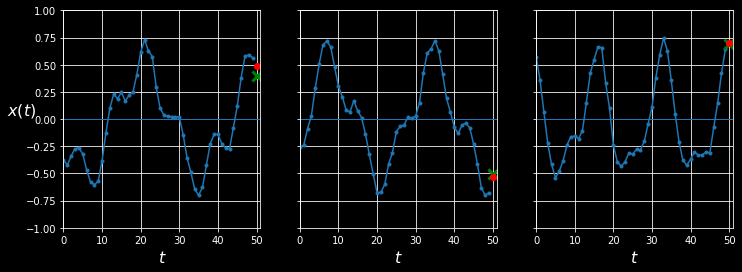

In [33]:
y_pred = model.predict(X_valid)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

In [34]:
%%time
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])
optimizer = keras.optimizers.Adam(lr=0.005)
#model.compile(optimizer="adam", loss="mse")
model.compile(optimizer=optimizer, loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

CPU times: user 3min 28s, sys: 21 s, total: 3min 49s
Wall time: 1min 20s


In [35]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0034


0.003420464927330613

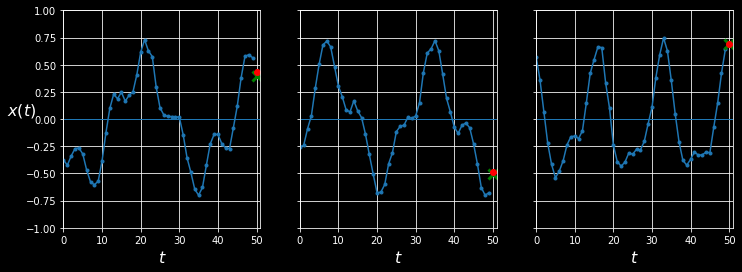

In [36]:
y_pred = model.predict(X_valid)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

**(?)** Try to show that RNN can be trained on sequences of different lengths and can infer on sequences of different lengths as well.

**(R)**
- Inference on diff lengths:

In [41]:
series_new = generate_time_series(5, 2*n_steps + 1)
X_new, y_new = series_new[:, :2*n_steps], series_new[:, -1]
pred_new = model.predict(X_new)
pred_new, y_new

(array([[ 0.33274493],
        [ 0.2899977 ],
        [-0.4803691 ],
        [-0.37422994],
        [-0.44167802]], dtype=float32),
 array([[ 0.5052652 ],
        [ 0.3524674 ],
        [-0.4907119 ],
        [-0.39301023],
        [-0.6376053 ]], dtype=float32))

In [42]:
pred_new.shape, y_new.shape

((5, 1), (5, 1))

In [44]:
series_new = generate_time_series(7, n_steps // 2 + 1)
X_new, y_new = series_new[:, :n_steps // 2], series_new[:, -1]
pred_new = model.predict(X_new)
pred_new, y_new

(array([[-0.16801138],
        [ 0.58852416],
        [-0.7848022 ],
        [-0.5436518 ],
        [-0.09367154],
        [ 0.13748685],
        [ 0.7243376 ]], dtype=float32),
 array([[-0.2530833 ],
        [ 0.39547738],
        [-0.5146921 ],
        [-0.22453915],
        [ 0.03977684],
        [ 0.45008394],
        [ 0.6288571 ]], dtype=float32))

In [45]:
pred_new.shape, y_new.shape

((7, 1), (7, 1))

- Training on diff lengths is harder to code, because the `X` as an ndarray must have fixed shape; still, one can separate into two `X`'s and conduct the training in two phases. I think it's doable, but it is not very interesting to do so.

## Forecasting Several Time Steps Ahead

In [56]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

In [57]:
y_pred_one = model.predict(X[:, :])
y_pred_one

array([[0.5292703]], dtype=float32)

In [58]:
y_pred_one = model.predict(X[:, :])[:, np.newaxis, :]
y_pred_one

array([[[0.5292703]]], dtype=float32)

In [59]:
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

In [60]:
Y_pred.shape, Y_new.shape

((1, 10, 1), (1, 10, 1))

In [67]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    #plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "go-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "gx-", label="Actual", markersize=10, mew=3)
    #plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10, mew=3)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast")
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

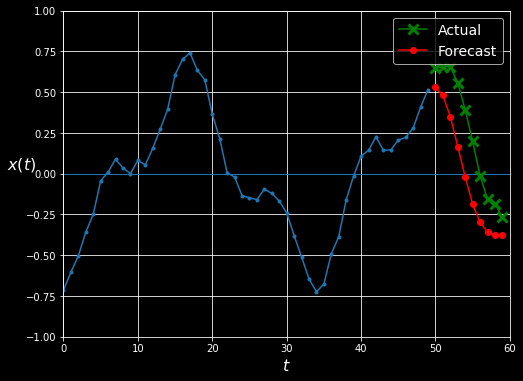

In [68]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Let's try to measure the mse of this.

In [69]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [70]:
X = X_valid
y_pred_one = model.predict(X)
y_pred_one.shape

(2000, 1)

In [71]:
X.shape

(2000, 50, 1)

In [72]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
X.shape

(2000, 60, 1)

In [73]:
Y_pred = X[:, n_steps:, 0]
Y_pred.shape

(2000, 10)

In [74]:
Y_valid.shape

(2000, 10)

In [75]:
mean_squared_error(Y_valid, Y_pred)

0.03279805

In [76]:
Y_naive_pred = Y_valid[:, -1:]
Y_naive_pred.shape, Y_valid.shape

((2000, 1), (2000, 10))

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0222

In [79]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 23ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0118 - val_lo

## Todo
01. Try _exponential moving average_ in the **Baseline Metrics** part.